L'équipe pour réaliser ce projet est constituée de : Thomas Bodart, Maceo Duriez et Marc-César Garcia-Grenet

Vous trouverez ci-dessous les deux configurations (continuous_actions et stable_baselines) que nous avons retenues pour le projet.

In [184]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import Counter
import highway_env
import torch
import torch.nn as nn
from copy import deepcopy
from collections import deque
import random

In [ ]:
%matplotlib inline
def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done:
        action = agent.get_action(state, epsilon=0)
        state, reward, terminated, truncated, _ = display_env.step(action)
        done = terminated or truncated
        rewards += reward
        if display: 
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f'total episode reward {rewards}')

def eval_agent(agent, env, n_sim=10):
    """    
    Monte Carlo evaluation of the agent.

    Repeat n_sim times:
        * Run the agent policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done: 
            action = agent.get_action(state, use_epsilon=False)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards

class RandomAgent: 
    def __init__(self, observation_space, action_space):
        self.action_space = action_space
        return
    
    def get_action(self, state, **kwargs):
        return self.action_space.sample()
    
    def update(self):
        pass

Some utilities functions: train, curves

In [273]:
def train(env, agent, N_episodes, eval_every=100, reward_threshold=300, n_eval=10, save_model=False):
    total_time = 0
    all_rewards = []
    all_lengths = []
    eval_rewards = []
    
    for ep in tqdm(range(N_episodes), desc="Training..."):
        done = False
        state, _ = env.reset()
        ep_reward = 0
        steps = 0

        while not done: 
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            if action == 4:
                actual_reward = reward / 10 - 0.1
            
            elif action == 3:
                actual_reward = reward * 10
            
            elif action != 0:
                actual_reward = reward + 0.0001

            else:
                actual_reward = reward
            
            # agent.store_transition(state, action, actual_reward, next_state, terminated)
            agent.store_transition(state, action, reward, next_state, terminated)
            agent.update()

            state = next_state
            done = terminated or truncated

            ep_reward += reward
            steps += 1
            total_time += 1

        all_rewards.append(ep_reward)
        all_lengths.append(steps)

        if (ep + 1) % eval_every == 0:
            mean_eval_reward = np.mean(eval_agent(agent, env, n_sim=n_eval))
            eval_rewards.append((ep + 1, mean_eval_reward))
            print(f"[Episode {ep+1}] Eval reward: {mean_eval_reward:.2f} | Train reward: {ep_reward:.2f} | Steps: {steps}")
            
            if save_model:
                torch.save(agent.policy_net.state_dict(), f"model_ep{ep+1}.pt")

            if mean_eval_reward >= reward_threshold:
                print("Reward threshold reached! Stopping early.")
                break

    print("\n Training complete.")
    _plot_training_curves(all_rewards, eval_rewards)
    return all_rewards, eval_rewards, all_lengths


def _plot_training_curves(all_rewards, eval_rewards):
    plt.figure(figsize=(12, 5))

    # Smoothed training reward
    smoothed_rewards = np.convolve(all_rewards, np.ones(10) / 10, mode='valid')
    plt.plot(smoothed_rewards, label='Train Reward (smoothed)', alpha=0.7)

    if eval_rewards:
        eval_eps, eval_vals = zip(*eval_rewards)
        plt.plot(eval_eps, eval_vals, 'o-', label='Eval Reward', color='red')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training and Evaluation Reward Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Task 1: Pre-specified environment
Let us first define the environment

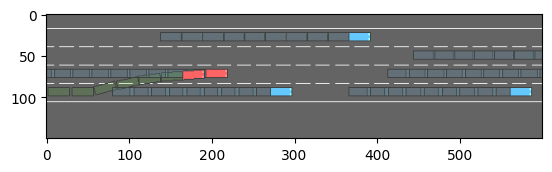

total episode reward 18.676164170426546


In [187]:

config_dict = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "duration": 60,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()


run_one_episode(env, RandomAgent(env.observation_space, env.action_space))

## General comments on the environment
### Observation space:
The observation space is a 8x8 grid, with the following channels (as in image):
- Presence: 1 if a car is here, 0 otherwise
- x and y: relative position
- vx, vy: relative velocities
- cos_h, sin_h: angle

### Action space:
There is 5 possible actions:
- IDLE: do nothing
- LEFT: go left
- RIGHT: go right
- FASTER: go faster
- SLOWER: go slower


In [188]:
print("Observation space shape: ", env.observation_space.shape)
print("Action space shape", env.action_space)


Observation space shape:  (7, 8, 8)
Action space shape Discrete(5)


## DQN Implementation
### Neural Network
Let us define the neural network for DQN. Since the observation space looks like an 8x8 image (with 7 channels), we will use CNN

In [189]:
class CNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.ln1 = nn.LayerNorm([16, 8, 8])
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.ln2 = nn.LayerNorm([32, 8, 8])
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 5)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    
    def forward(self, observation_space: torch.FloatTensor):
        x = self.relu(self.ln1(self.conv1(observation_space)))
        x = self.relu(self.ln2(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
ex = torch.tensor([env.observation_space.sample()])
model = CNN()
model(ex)

tensor([[0.0920, 0.1777, 0.1148, 0.0065, 0.0507]], grad_fn=<AddmmBackward0>)

### Agent
Let us now define the agent. 

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        learning_rate,
        weight_decay,
        model,
        optimizer,
        buffer_capacity
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

        self.policy_net = model.to(self.device)
        self.target_net = deepcopy(model).to(self.device)
        self.target_net.eval()

        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

        self.steps = 0
        self.update_target_every = 100

        self.action_counter = Counter()
        self.epsilon = 0.1

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        transitions = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.tensor(states, device=self.device, dtype=torch.float32)
        actions = torch.tensor(actions, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32)
        dones = torch.tensor(dones, device=self.device, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = torch.nn.functional.smooth_l1_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def get_action(self, state, use_epsilon=True):
        if use_epsilon and random.random() < self.epsilon:
            action = self.action_space.sample()
            self.action_counter[action] += 1
            return action 

        state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        
        action = q_values.argmax().item()
        self.action_counter[action] += 1
        return action
        
    def reset_action_counter(self):
        self.action_counter = Counter()


mean reward before training =  32.65874795345529


Training...:  10%|█         | 50/500 [00:18<06:01,  1.24it/s]

[Episode 50] Eval reward: 8.95 | Train reward: 5.67 | Steps: 8


Training...:  20%|██        | 100/500 [00:37<08:34,  1.29s/it]

[Episode 100] Eval reward: 16.71 | Train reward: 26.00 | Steps: 27


Training...:  30%|███       | 150/500 [01:05<07:06,  1.22s/it]

[Episode 150] Eval reward: 17.91 | Train reward: 23.33 | Steps: 24


Training...:  40%|████      | 200/500 [01:42<11:07,  2.23s/it]

[Episode 200] Eval reward: 33.45 | Train reward: 33.62 | Steps: 39


Training...:  50%|█████     | 250/500 [02:21<08:23,  2.02s/it]

[Episode 250] Eval reward: 13.15 | Train reward: 48.23 | Steps: 60


Training...:  60%|██████    | 300/500 [02:58<06:36,  1.98s/it]

[Episode 300] Eval reward: 27.87 | Train reward: 26.31 | Steps: 34


Training...:  70%|███████   | 350/500 [03:34<03:34,  1.43s/it]

[Episode 350] Eval reward: 23.87 | Train reward: 16.06 | Steps: 19


Training...:  80%|████████  | 400/500 [04:15<02:58,  1.79s/it]

[Episode 400] Eval reward: 26.62 | Train reward: 8.49 | Steps: 12


Training...:  90%|█████████ | 450/500 [04:52<01:21,  1.63s/it]

[Episode 450] Eval reward: 15.57 | Train reward: 50.45 | Steps: 60


Training...: 100%|██████████| 500/500 [05:30<00:00,  1.51it/s]

[Episode 500] Eval reward: 28.16 | Train reward: 11.28 | Steps: 12

 Training complete.


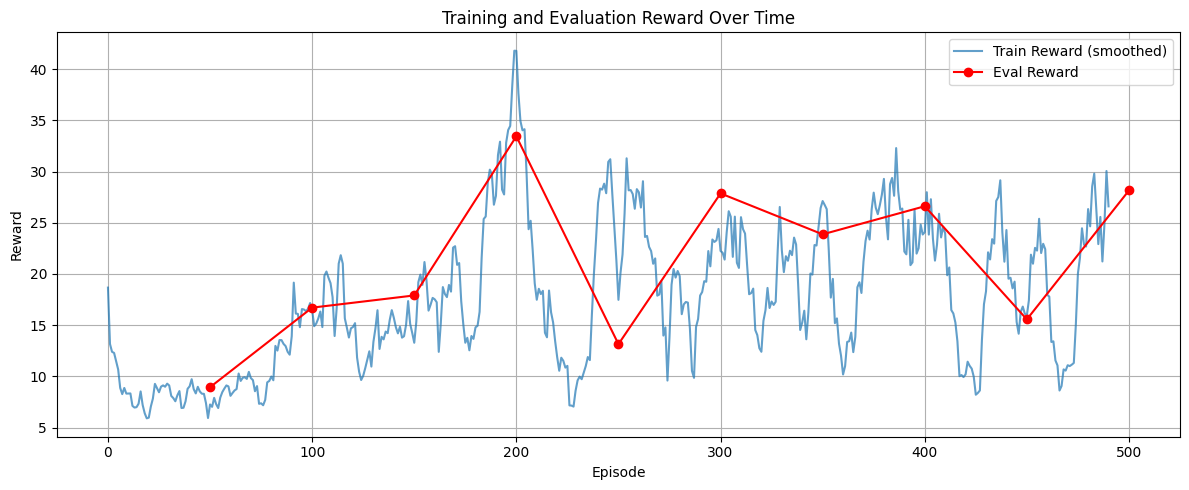

mean reward after training =  28.155675076938184


In [191]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()

action_space = env.action_space
observation_space = env.observation_space

gamma = .99
episode_batch_size = 64
learning_rate = 1e-3
weight_decay = 0
model=CNN()
optimizer = torch.optim.Adam
N_episodes = 500

agent = DQNAgent(
    action_space=action_space,
    observation_space=observation_space,
    gamma=gamma,
    batch_size=episode_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    model=model,
    optimizer=optimizer,
    buffer_capacity=1000,
)

print("mean reward before training = ", np.mean(eval_agent(agent, env, 10)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 10)))


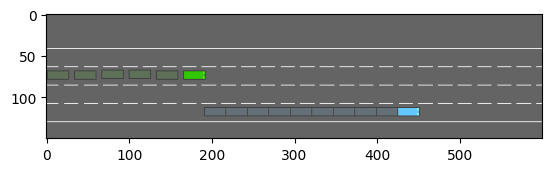

total episode reward 52.15069982164833
Counter({3: 40, 4: 11, 0: 5, 2: 4})


In [201]:
env.reset()

agent.reset_action_counter()

run_one_episode(env, agent)

print(agent.action_counter)

## Bonus: Double DQN

In [ ]:
class DoubleDQNAgent:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        learning_rate,
        weight_decay,
        model,
        optimizer,
        buffer_capacity
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

        self.policy_net = model.to(self.device)
        self.target_net = deepcopy(model).to(self.device)
        self.target_net.eval()

        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

        self.steps = 0
        self.update_target_every = 100

        self.action_counter = Counter()
        self.epsilon = 0.1

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        transitions = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.tensor(states, device=self.device, dtype=torch.float32)
        actions = torch.tensor(actions, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32)
        dones = torch.tensor(dones, device=self.device, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = torch.nn.functional.smooth_l1_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def get_action(self, state, use_epsilon=True):
        if use_epsilon and random.random() < self.epsilon:
            action = self.action_space.sample()
            self.action_counter[action] += 1
            return action 

        state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        
        action = q_values.argmax().item()
        self.action_counter[action] += 1
        return action
        
    def reset_action_counter(self):
        self.action_counter = Counter()

mean reward before training =  45.26515600315956


Training...:   5%|▌         | 51/1000 [00:17<05:59,  2.64it/s]

[Episode 50] Eval reward: 4.58 | Train reward: 3.89 | Steps: 5


Training...:  10%|█         | 101/1000 [00:28<06:10,  2.43it/s]

[Episode 100] Eval reward: 3.85 | Train reward: 18.37 | Steps: 19


Training...:  15%|█▌        | 151/1000 [00:43<05:31,  2.56it/s]

[Episode 150] Eval reward: 7.74 | Train reward: 1.81 | Steps: 3


Training...:  20%|██        | 201/1000 [01:06<14:26,  1.08s/it]

[Episode 200] Eval reward: 25.86 | Train reward: 6.81 | Steps: 10


Training...:  25%|██▌       | 251/1000 [01:30<12:36,  1.01s/it]

[Episode 250] Eval reward: 19.18 | Train reward: 10.96 | Steps: 12


Training...:  30%|███       | 300/1000 [01:51<08:10,  1.43it/s]

[Episode 300] Eval reward: 6.24 | Train reward: 9.25 | Steps: 15


Training...:  35%|███▌      | 350/1000 [02:10<06:37,  1.63it/s]

[Episode 350] Eval reward: 7.34 | Train reward: 4.71 | Steps: 7


Training...:  40%|████      | 400/1000 [02:27<08:32,  1.17it/s]

[Episode 400] Eval reward: 8.92 | Train reward: 5.43 | Steps: 8


Training...:  45%|████▌     | 450/1000 [02:45<04:56,  1.85it/s]

[Episode 450] Eval reward: 9.12 | Train reward: 3.03 | Steps: 4


Training...:  50%|█████     | 500/1000 [03:02<07:07,  1.17it/s]

[Episode 500] Eval reward: 12.31 | Train reward: 7.12 | Steps: 8


Training...:  55%|█████▌    | 550/1000 [03:20<05:29,  1.36it/s]

[Episode 550] Eval reward: 9.07 | Train reward: 7.12 | Steps: 10


Training...:  60%|██████    | 600/1000 [03:41<06:25,  1.04it/s]

[Episode 600] Eval reward: 12.90 | Train reward: 6.55 | Steps: 9


Training...:  65%|██████▌   | 650/1000 [04:02<03:39,  1.59it/s]

[Episode 650] Eval reward: 7.30 | Train reward: 5.26 | Steps: 7


Training...:  70%|███████   | 700/1000 [04:37<11:51,  2.37s/it]

[Episode 700] Eval reward: 24.89 | Train reward: 41.66 | Steps: 60


Training...:  75%|███████▌  | 750/1000 [05:26<11:03,  2.65s/it]

[Episode 750] Eval reward: 37.11 | Train reward: 1.31 | Steps: 2


Training...:  80%|████████  | 800/1000 [06:09<06:31,  1.96s/it]

[Episode 800] Eval reward: 24.70 | Train reward: 9.94 | Steps: 14


Training...:  85%|████████▌ | 850/1000 [06:53<03:51,  1.54s/it]

[Episode 850] Eval reward: 24.56 | Train reward: 5.81 | Steps: 7


Training...:  90%|█████████ | 900/1000 [07:39<03:54,  2.34s/it]

[Episode 900] Eval reward: 22.08 | Train reward: 46.16 | Steps: 59


Training...:  95%|█████████▌| 950/1000 [08:11<01:08,  1.37s/it]

[Episode 950] Eval reward: 21.37 | Train reward: 2.68 | Steps: 4


Training...: 100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]

[Episode 1000] Eval reward: 14.63 | Train reward: 9.97 | Steps: 15

 Training complete.


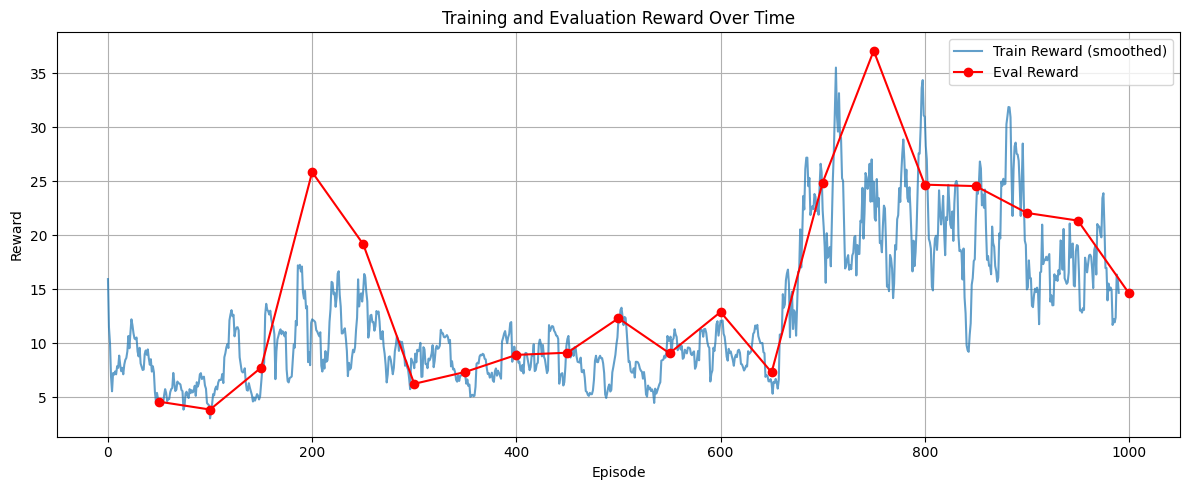

mean reward after training =  14.630302011346348


In [229]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()

action_space = env.action_space
observation_space = env.observation_space

gamma = .99
episode_batch_size = 64
learning_rate = 1e-4
weight_decay = 0
model=CNN()
optimizer = torch.optim.Adam
N_episodes = 1000

agent = DoubleDQNAgent(
    action_space=action_space,
    observation_space=observation_space,
    gamma=gamma,
    batch_size=episode_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    model=model,
    optimizer=optimizer,
    buffer_capacity=10_000,
)

print("mean reward before training = ", np.mean(eval_agent(agent, env, 10)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 10)))


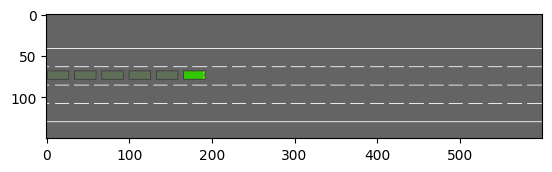

total episode reward 45.9212297230984
Counter({3: 42, 0: 10, 4: 4, 2: 4})


In [240]:
env.reset(seed=5)

agent.reset_action_counter()

run_one_episode(env, agent)

print(agent.action_counter)

## Further: Prioritized Experience Replay

In [254]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0

    def push(self, *transition):
        max_priority = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition

        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            probs = self.priorities
        else:
            probs = self.priorities[:self.pos]

        probs = probs ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for i, p in zip(indices, priorities):
            self.priorities[i] = p


In [255]:
class PERDoubleDQNAgent:
    def __init__(
        self,
        action_space,
        observation_space,
        gamma,
        batch_size,
        learning_rate,
        weight_decay,
        model,
        optimizer,
        buffer_capacity
    ):
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

        self.policy_net = model.to(self.device)
        self.target_net = deepcopy(model).to(self.device)
        self.target_net.eval()

        self.optimizer = optimizer(self.policy_net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.replay_buffer = PrioritizedReplayBuffer(capacity=buffer_capacity)

        self.steps = 0
        self.update_target_every = 100

        self.action_counter = Counter()

        self.epsilon_start = 0.1
        self.epsilon_end = 0.05
        self.epsilon_decay = 500
        self.epsilon = self.epsilon_start

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        (transitions, indices, weights) = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        weights = torch.tensor(weights, device=self.device, dtype=torch.float32).unsqueeze(1)


        states = torch.tensor(states, device=self.device, dtype=torch.float32)
        actions = torch.tensor(actions, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, device=self.device, dtype=torch.float32)
        dones = torch.tensor(dones, device=self.device, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        td_errors = (q_values - target_q_values).detach().squeeze().abs().cpu().numpy()
        loss = (torch.nn.functional.smooth_l1_loss(q_values, target_q_values, reduction='none') * weights).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.replay_buffer.update_priorities(indices, td_errors + 1e-5)

        self.steps += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-1. * self.step / self.epsilon_decay)
        if self.steps % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def get_action(self, state, use_epsilon=True):

        if use_epsilon and random.random() < self.epsilon:
            action = self.action_space.sample()
            self.action_counter[action] += 1
            return action 

        state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        
        action = q_values.argmax().item()
        self.action_counter[action] += 1
        return action
        
    def reset_action_counter(self):
        self.action_counter = Counter()

mean reward before training =  46.33807266982547


Training...:   5%|▌         | 50/1000 [00:14<08:27,  1.87it/s]

[Episode 50] Eval reward: 8.17 | Train reward: 1.37 | Steps: 3


Training...:  10%|█         | 101/1000 [00:29<07:02,  2.13it/s]

[Episode 100] Eval reward: 8.43 | Train reward: 2.31 | Steps: 3


Training...:  15%|█▌        | 150/1000 [00:55<17:07,  1.21s/it]

[Episode 150] Eval reward: 14.76 | Train reward: 7.26 | Steps: 10


Training...:  20%|██        | 200/1000 [01:25<14:38,  1.10s/it]

[Episode 200] Eval reward: 9.46 | Train reward: 45.92 | Steps: 49


Training...:  25%|██▌       | 250/1000 [01:42<11:06,  1.13it/s]

[Episode 250] Eval reward: 12.11 | Train reward: 1.37 | Steps: 2


Training...:  30%|███       | 300/1000 [02:17<10:18,  1.13it/s]

[Episode 300] Eval reward: 8.32 | Train reward: 4.78 | Steps: 8


Training...:  35%|███▌      | 350/1000 [02:39<09:00,  1.20it/s]

[Episode 350] Eval reward: 6.84 | Train reward: 9.02 | Steps: 12


Training...:  40%|████      | 401/1000 [02:59<05:58,  1.67it/s]

[Episode 400] Eval reward: 10.46 | Train reward: 4.06 | Steps: 6


Training...:  45%|████▌     | 451/1000 [03:16<04:57,  1.84it/s]

[Episode 450] Eval reward: 6.37 | Train reward: 4.46 | Steps: 7


Training...:  50%|█████     | 500/1000 [03:40<10:12,  1.23s/it]

[Episode 500] Eval reward: 17.27 | Train reward: 21.26 | Steps: 26


Training...:  55%|█████▌    | 550/1000 [04:11<09:53,  1.32s/it]

[Episode 550] Eval reward: 13.41 | Train reward: 6.21 | Steps: 10


Training...:  60%|██████    | 601/1000 [04:39<07:02,  1.06s/it]

[Episode 600] Eval reward: 19.83 | Train reward: 12.15 | Steps: 13


Training...:  65%|██████▌   | 650/1000 [05:12<08:59,  1.54s/it]

[Episode 650] Eval reward: 14.63 | Train reward: 20.93 | Steps: 26


Training...:  70%|███████   | 700/1000 [05:43<08:57,  1.79s/it]

[Episode 700] Eval reward: 18.11 | Train reward: 39.17 | Steps: 49


Training...:  75%|███████▌  | 750/1000 [06:14<03:17,  1.26it/s]

[Episode 750] Eval reward: 9.86 | Train reward: 5.06 | Steps: 7


Training...:  80%|████████  | 800/1000 [06:50<05:16,  1.58s/it]

[Episode 800] Eval reward: 16.49 | Train reward: 6.02 | Steps: 9


Training...:  85%|████████▌ | 850/1000 [07:28<04:16,  1.71s/it]

[Episode 850] Eval reward: 25.79 | Train reward: 12.24 | Steps: 16


Training...:  90%|█████████ | 900/1000 [08:11<03:23,  2.03s/it]

[Episode 900] Eval reward: 22.71 | Train reward: 18.92 | Steps: 28


Training...:  95%|█████████▌| 950/1000 [08:52<01:38,  1.97s/it]

[Episode 950] Eval reward: 26.34 | Train reward: 12.51 | Steps: 15


Training...: 100%|██████████| 1000/1000 [09:35<00:00,  1.74it/s]

[Episode 1000] Eval reward: 32.59 | Train reward: 4.51 | Steps: 6

 Training complete.


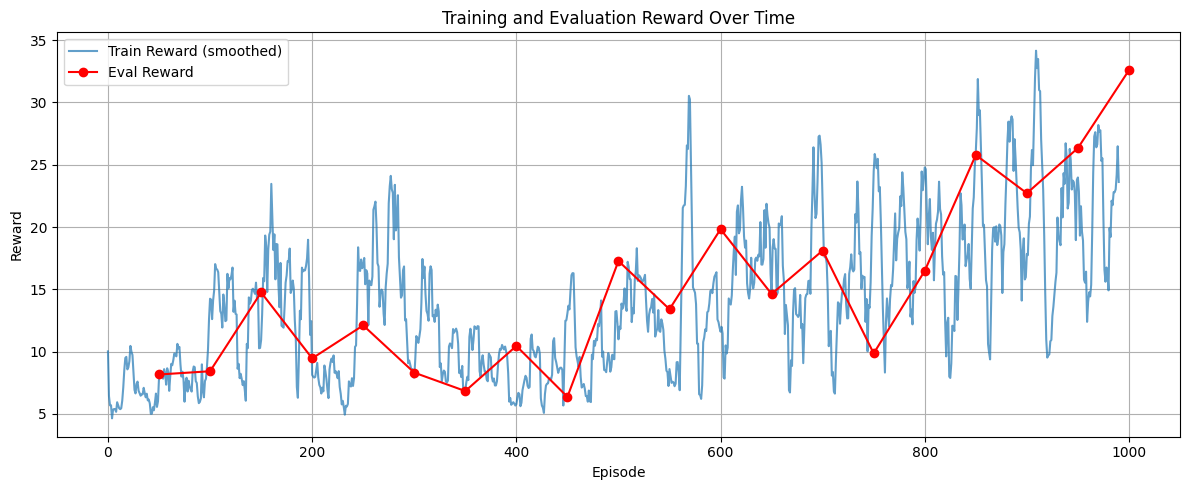

mean reward after training =  32.58687620967679


In [256]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()

action_space = env.action_space
observation_space = env.observation_space

gamma = .99
episode_batch_size = 64
learning_rate = 1e-4
weight_decay = 0
model=CNN()
optimizer = torch.optim.Adam
N_episodes = 1000

agent = DoubleDQNAgent(
    action_space=action_space,
    observation_space=observation_space,
    gamma=gamma,
    batch_size=episode_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    model=model,
    optimizer=optimizer,
    buffer_capacity=10_000,
)

print("mean reward before training = ", np.mean(eval_agent(agent, env, 10)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 10)))


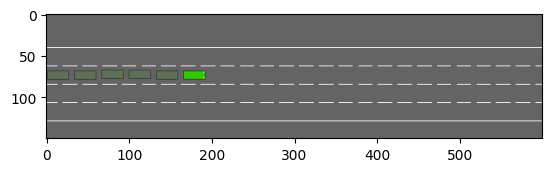

total episode reward 46.83835108940829
Counter({3: 53, 0: 4, 2: 2, 4: 1})


In [268]:
env.reset()

agent.reset_action_counter()

run_one_episode(env, agent)

print(agent.action_counter)

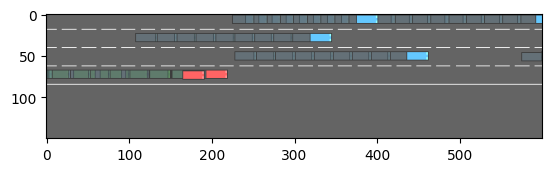

total episode reward 3.550251924360725


In [283]:

config_dict = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "duration": 80,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.1,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.5,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0.0001,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()


run_one_episode(env, RandomAgent(env.observation_space, env.action_space))

mean reward before training =  7.638608972411751


Training...:   5%|▌         | 50/1000 [00:24<24:45,  1.56s/it]

[Episode 50] Eval reward: 17.07 | Train reward: 28.49 | Steps: 32


Training...:  10%|█         | 100/1000 [00:53<23:43,  1.58s/it]

[Episode 100] Eval reward: 21.37 | Train reward: 50.53 | Steps: 75


Training...:  15%|█▌        | 150/1000 [01:47<58:53,  4.16s/it]

[Episode 150] Eval reward: 51.51 | Train reward: 57.77 | Steps: 80


Training...:  20%|██        | 200/1000 [02:40<54:00,  4.05s/it]

[Episode 200] Eval reward: 49.23 | Train reward: 60.37 | Steps: 80


Training...:  25%|██▌       | 250/1000 [03:40<32:46,  2.62s/it]

[Episode 250] Eval reward: 31.25 | Train reward: 21.01 | Steps: 28


Training...:  30%|███       | 300/1000 [04:37<34:15,  2.94s/it]

[Episode 300] Eval reward: 41.10 | Train reward: 33.74 | Steps: 48


Training...:  35%|███▌      | 350/1000 [05:32<31:04,  2.87s/it]

[Episode 350] Eval reward: 45.52 | Train reward: 5.39 | Steps: 8


Training...:  40%|████      | 400/1000 [06:34<29:58,  3.00s/it]

[Episode 400] Eval reward: 46.26 | Train reward: 49.23 | Steps: 59


Training...:  45%|████▌     | 450/1000 [07:31<32:40,  3.56s/it]

[Episode 450] Eval reward: 45.29 | Train reward: 25.63 | Steps: 38


Training...:  50%|█████     | 500/1000 [08:22<20:13,  2.43s/it]

[Episode 500] Eval reward: 32.57 | Train reward: 8.69 | Steps: 12


Training...:  55%|█████▌    | 550/1000 [09:12<18:28,  2.46s/it]

[Episode 550] Eval reward: 38.72 | Train reward: 7.78 | Steps: 9


Training...:  60%|██████    | 600/1000 [10:16<21:15,  3.19s/it]

[Episode 600] Eval reward: 41.52 | Train reward: 13.35 | Steps: 17


Training...:  65%|██████▌   | 650/1000 [11:12<16:35,  2.84s/it]

[Episode 650] Eval reward: 36.09 | Train reward: 15.74 | Steps: 19


Training...:  70%|███████   | 700/1000 [12:01<17:12,  3.44s/it]

[Episode 700] Eval reward: 41.83 | Train reward: 64.00 | Steps: 80


Training...:  75%|███████▌  | 750/1000 [12:55<13:58,  3.35s/it]

[Episode 750] Eval reward: 47.02 | Train reward: 63.67 | Steps: 80


Training...:  80%|████████  | 800/1000 [13:59<14:42,  4.41s/it]

[Episode 800] Eval reward: 47.71 | Train reward: 52.15 | Steps: 72


Training...:  85%|████████▌ | 850/1000 [14:57<09:56,  3.98s/it]

[Episode 850] Eval reward: 49.60 | Train reward: 21.13 | Steps: 26


Training...:  90%|█████████ | 900/1000 [16:01<06:15,  3.75s/it]

[Episode 900] Eval reward: 39.70 | Train reward: 66.17 | Steps: 80


Training...:  95%|█████████▌| 950/1000 [16:49<01:49,  2.19s/it]

[Episode 950] Eval reward: 25.76 | Train reward: 14.54 | Steps: 17


Training...: 100%|██████████| 1000/1000 [17:37<00:00,  1.06s/it]

[Episode 1000] Eval reward: 21.41 | Train reward: 28.08 | Steps: 36

 Training complete.


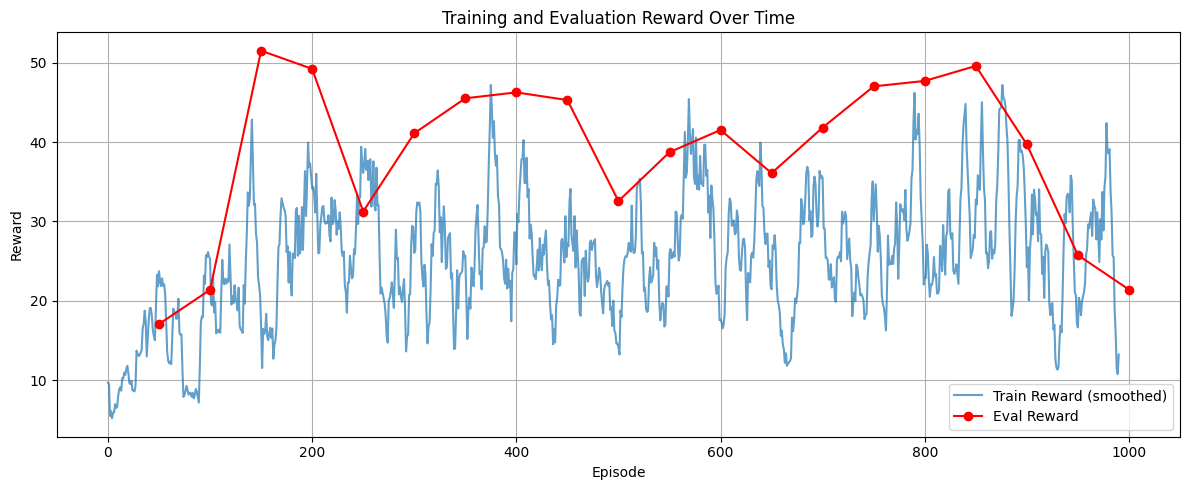

mean reward after training =  21.410163742846642


In [284]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config = config_dict)
env.reset()

action_space = env.action_space
observation_space = env.observation_space

gamma = .99
episode_batch_size = 64
learning_rate = 1e-4
weight_decay = 0
model=CNN()
optimizer = torch.optim.Adam
N_episodes = 1000

agent = DoubleDQNAgent(
    action_space=action_space,
    observation_space=observation_space,
    gamma=gamma,
    batch_size=episode_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    model=model,
    optimizer=optimizer,
    buffer_capacity=10_000,
)

print("mean reward before training = ", np.mean(eval_agent(agent, env, 10)))
# Run the training loop
train(env, agent, N_episodes, eval_every=50,)

# Evaluate the final policy
print("mean reward after training = ", np.mean(eval_agent(agent, env, 10)))


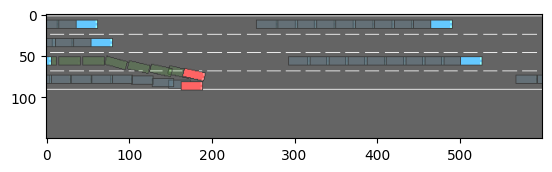

total episode reward 52.87060418650749
Counter({2: 29, 1: 21, 4: 9, 3: 6, 0: 2})


In [302]:
env.reset()

agent.reset_action_counter()

run_one_episode(env, agent)

print(agent.action_counter)

# Task 2:

In [ ]:
racing_config = {
    'action': {
        'lateral': True,
        'longitudinal': True,
        'target_speeds': [0, 30, 50, 80],
        'type': 'ContinuousAction'
    },
    'action_reward': -0.1,
    'collision_reward': -5,
    'controlled_vehicles': 1,
    'duration': 1200,
    'lane_centering_cost': 1,
    'lane_centering_reward': 0.1,
    'manual_control': False,
    'observation': {
        'align_to_vehicle_axes': True,
        'as_image': False,
        'features': ['presence', 'velocity', 'acceleration'],
        'grid_size': [[-30, 30], [-30, 30]],
        'grid_step': [5, 5],
        'type': 'OccupancyGrid'
    },
    'offscreen_rendering': False,
    'other_vehicles': 3, 
    'other_vehicles_type': 'highway_env.vehicle.behavior.AggressiveVehicle',
    'policy_frequency': 5,
    'real_time_rendering': True,
    'render_agent': True,
    'scaling': 6,
    'screen_height': 800,
    'screen_width': 1200,
    'show_trajectories': False,
    'simulation_frequency': 15,
}

env = gym.make("racetrack-v0", render_mode="rgb_array", config=racing_config)
env.reset()

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
env.close()

KeyboardInterrupt: 

In [ ]:
stablebaselines_config = {'action': {'type': 'DiscreteMetaAction'},
'centering_position': [0.3, 0.5],
'collision_reward': -1.0,
'controlled_vehicles': 1,
'duration': 45,
'ego_spacing': 2,
'high_speed_reward': 1.0,
'initial_lane_id': None,
'lane_change_reward': 0.2,
'lanes_count': 4,
'manual_control': False,
'normalize_reward': True,
'observation': {'type': 'Kinematics'},
'offroad_terminal': False,
'offscreen_rendering': False,
'other_vehicles_type': 'highway_env.vehicle.behavior.AggressiveVehicle',
'policy_frequency': 1,
'real_time_rendering': False,
'render_agent': True,
'reward_speed_range': [30, 80],
'right_lane_reward': -0.1,
'scaling': 6.0,
'screen_height': 300,
'screen_width': 1200,
'show_trajectories': False,
'simulation_frequency': 15,
'vehicles_count': 100,
'vehicles_density': 2}

env = gym.make("highway-fast-v0", render_mode="rgb_array", config=stablebaselines_config)
env.reset()

for _ in range(100):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()

plt.imshow(env.render())
env.close()

AttributeError: 'NoneType' object has no attribute 'get_image'